# MODNet 'matbench_expt_gap' benchmarking

The `matbench_expt_gap` dataset contains measured band gaps for 4604 compositions of inorganic semiconductors from Zhuo *et al.*, JPCL.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset, get_all_dataset_info
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [ ]:
Markdown(filename="./README.md")

## Data exploration

In [2]:
df = load_dataset("matbench_expt_gap")
df["composition"] = df["composition"].map(Composition)

### Target space

In [3]:
df.describe()

,gap expt
count,4604.000000
mean,0.975951
std,1.445034
min,0.000000
25%,0.000000
50%,0.000000
75%,1.812500
max,11.700000


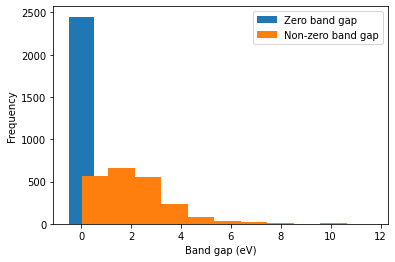

In [4]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df.where(df["gap expt"] == 0)["gap expt"], bins=1, density=False, label="Zero band gap")
ax.hist(df.where(df["gap expt"] > 0)["gap expt"], bins=11, density=False, label="Non-zero band gap")
ax.set_ylabel("Frequency")
ax.set_xlabel("Band gap (eV)")
ax.legend()

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [3]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [4]:
PRECOMPUTED_MODDATA = "./precomputed/expt_gap_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_expt_gap")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["E_g"].tolist(), 
        target_names=["gap expt (eV)"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8)
    )
    data.featurize()
    data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f9dd8937280> object, created with modnet version 0.1.8~develop


In [ ]:
#data.optimal_features=None
#data.cross_nmi = None
#data.num_classes = {"E_g":0}
#data.feature_selection(n=-1)
#data.save("./precomputed/expt_gap_benchmark_moddata_MPCNMI.pkl.gz")

## Training

In [ ]:
from modnet.matbench.benchmark import matbench_benchmark


best_settings = {
    "increase_bs":False,
    "num_neurons": [[256], [128], [16], [16]],
    "n_feat": len(data.optimal_features),
    "lr": 0.007,
    "epochs": 400,
    "verbose": 0,
    "act": "elu",
    "batch_size": 64,
    "loss": "mae",
}

results = matbench_benchmark(data, [[["E_g"]]], {"E_g": 1}, best_settings, save_folds=True)
np.mean(results['scores'])

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f9cd31dacd0> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f1!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.378
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.005, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.365
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.397
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 

Model #1: MAE = 0.32439498602292305


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f9cd31dabe0> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f2!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.388
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.005, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.367
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.357
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 

Model #2: MAE = 0.3753118895562153


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f9cd24975e0> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f3!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.384
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.005, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.346
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.403
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 

Model #3: MAE = 0.3968596251271706


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f9cd24975e0> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f4!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.362
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.005, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.352
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.353
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 

Model #4: MAE = 0.3456083300678983


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f9cd24975e0> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f5!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.410
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.005, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.411
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.01, 'n_feat': 30, 'num_neurons': [[60], [30, 30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.400
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 

In [ ]:
best_settings = {
    "increase_bs":False,
    "num_neurons": [[256], [128], [16], [16]],
    "n_feat": 100,
    "lr": 0.007,
    "epochs": 400,
    "verbose": 0,
    "act": "elu",
    "batch_size": 64,
    "loss": "mae",
} #0.31

In [ ]:
for i in range(5):
    plt.plot(results["models"][i].history.history["loss"][10:])

In [ ]:
import seaborn as sns
reg_df = pd.DataFrame(
    np.array([
        [x for targ in results["targets"] for x in targ],
        [y for pred in results["predictions"] for y in pred],
        [e for err in results["errors"] for e in err]
    ]).T,
    columns=["targets", "predictions", "errors"]
)
splits = []
for i in range(5):
    for j in range(len(results["targets"][i])):
        splits.append(i)
reg_df["split"] = splits

In [ ]:
fig, ax = plt.subplots()
#ax.set_aspect("equal")
sns.scatterplot(data=reg_df, x="targets", y="predictions", hue="split", palette="Dark2", ax=ax, alpha=0.2)
sns.regplot(data=reg_df, x="targets", y="predictions", ax=ax, scatter=False)
# plt.plot(*ax.get_xlim(), *ax.get_xlim(), c="k",alpha=0.5)
ax.set_xlim(-1)
plt.xlabel("True")
plt.ylabel("Pred.")

In [ ]:
g = sns.jointplot(data=reg_df, x="errors", y="targets", hue="split", palette="Dark2", alpha=0.0, marginal_kws={"shade": False})
g.plot_joint(sns.scatterplot, hue=None, c="black", s=5, alpha=0.5)
g.plot_joint(sns.kdeplot, color="split", zorder=0, levels=5, alpha=0.5)